#### **Attention Mechanism and Transformers**

Based on and with modifications from  of http://d2l.ai/

#### **1. Queries, Keys, Values**

We design queries that operate on key-value pairs in such a manner as to be valid
regardless of the database soze -- The same query can have different answers from
the database -- The code executed to operate on a large state space -- There is
no need to simplify or compress the database to make operations effective.

Attention derives from the fact that the operation pays particular attention to
the terms for which the weight is significant. Attention generates a linear
combination of values contained in the database.

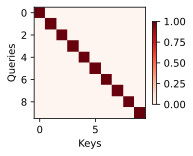

In [ ]:
attn_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attn_weights, xlabel='Keys', ylabel='Queries')
      ##titles=['Head %d' % i for i in range(1, 6)], figsize=(3, 3), cmap='Reds')

#### **2. Attention Pooling**

Nadaraya-Watson kernel regression is an early precursor to the current attention mechanisms. It can be used directly with little to no training for classification and regression. The attention weight is assigned according to similarity (or distance) between query and key, according to how many similar observations are available.

Kernels

$$
k(x, y) = \exp\left(-\frac{||x - y||^2}{2\sigma^2}\right) -  (Gaussian)
$$

$$
K(x) = \begin{cases}
  \frac{1}{2} & \text{if } |x| \le 1 \\
  0 & \text{otherwise}
\end{cases} -  (Boxcar)
$$


$$
K(x) = \begin{cases}
  \frac{3}{4}(1 - x^2) & \text{if } |x| \le 1 \\
  0 & \text{otherwise}
\end{cases} -  (Epanechikov)
$$

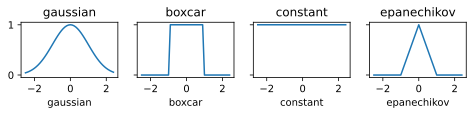

In [ ]:
''' Kernels and data
all kernels are translation and rotation invariant '''
def gaussian(x):
  return torch.exp(-x**2/2)
def constant(x):
  return 1.0 +0*x
def boxcar(x):
  return torch.abs(x) < 1.0 ##(x.abs() < 0.5).float()
def epanechikov(x):
  return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(8, 1))
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('gaussian', 'boxcar', 'constant', 'epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
  ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
  ax.set_title(kernel.__name__)
  ax.set_xlabel(name)

In [ ]:
'''
Different kernels correspond to different notions of range and smothness.
To see Nadaraya-Watson estimation in action, let's define some training data.
'''
def f(x):
  return 2* torch.sin(x) +x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.normal(0.0, 0.5, (n,))
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)
n_val = len(x_val)

''' With data and kernels we need a function that computes the kernel regression
estimates. We obtain relative kernel weights to perform some minor diagnsotics.
We compute the kernel between all training features, covariates x_train and all
validation features x_val. This yields a matrix, we normalize, and then when
multiplied with the training labels we obtain estimates.
Let each validation feature be a query, and each trainign feature-label be a
key-value pair. As a result, the normalized relative kernel weights are the
attention weights '''
def nadaraya_watson(x_train, y_train, x_val, kernel):
  dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
  k = kernel(dists).type(torch.float32)
  attention_w = k / k.sum(dim=0, keepdim=True)
  y_hat = y_train@attention_w   ##torch.matmul(y_train, attention_w)
  return y_hat, attention_w

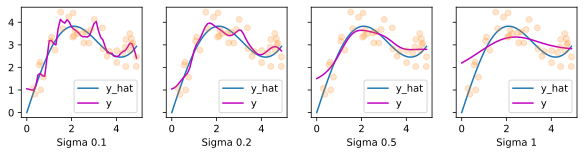

In [ ]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
  fig, axes = plt.subplots(1, len(kernels), sharey=True, figsize=(10, 2))
  for kernel, name, ax in zip(kernels, names, axes):
    y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
    if attention:
      pcm = ax.imshow(attention_w.detach().numpy(), cmap=plt.cm.Reds)
    else:
      ax.plot(x_val.detach().numpy(), y_val.detach().numpy(),)
      ax.plot(x_val.detach().numpy(), y_hat.detach().numpy(), 'm')
      ax.plot(x_train.detach().numpy(), y_train.detach().numpy(), 'o', alpha=.2)
    ax.set_xlabel(name)
    if not attention:
      ax.legend(['y_hat', 'y'])
  if attention:
    fig.colorbar(pcm, ax=axes, shrink=0.6)

plot(x_train, y_train, x_val, y_val, kernels, names)

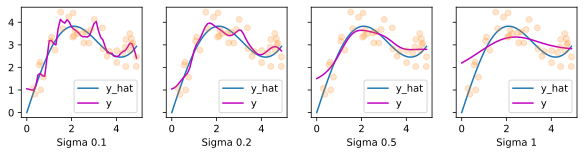

In [ ]:
''' Attention pooling
If we replaced the gaussian kernel with a different width, affects the outcome
the narrower the kernel the less smooth the estimate, and it adapts better to
the local variations
'''
sigmas = (.1, .2, .5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
  return (lambda x: torch.exp(-x**2 / 2 / sigma**2))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

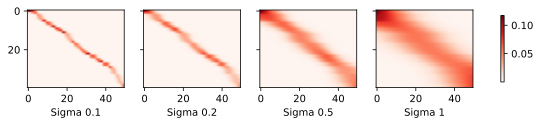

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

#### **Attention Scoring**

We used different distance based kernels, including gaussian kernel to model
interactions between queries and keys. Distance functions are slightly more
expensive to compute than inner products. As such with the softmax operation
to ensure non-negative attention weights, much of the work has gone into
attention scoring functions that are simpler to compute.

The attention function with a Gaussian kernel

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Dot Product Attention


- Attention from the Gaussian kernel (without exponentiation)
$$
\text{Attention}(Q, K) = -\|Q - K\|^2
$$


- Attention function as used in Transformers (Scaled Dot Product Attention)
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Batch Matrix Multiplication (BMM)
$$
\text{BMM}(Q, K^T) = S ;     S_b = Q_b K_b^T
$$

Additive Attention

$$
e_{ij} = v^T \tanh(W_q q_i + W_k k_j)
$$



Implementation of **Scaled Dot Product Attention**

Scaled dot-product attention requires thatboth the query and the key have the
same vector length, let's say d, and even in this case it can be addressed by
replacing qTk with qTMk where M is a suitability chosen matrix to translate
between both spaces. Here we assume the dimensons math.

In practice we think in minibatches for eficiency, such as computing attention
for n-queries and m-key-value pairs, where the queries and keys are of length
d and values of length v.
When applying this to a minibatch, we need the batch matrix multiplication.

In [ ]:
''' Implementation of scaled dot-product attention & dropout for regularization '''
class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    '''
    shape of queries: (batch_size, #of-queries, d)
    shape of keys: (batch_size, #of-key-value-pairs, d)
    shape of values: (batch_size, #of-key-value-pairs, value-dimension)
    shape of valid_lens: (batch_size, ) or (batch_size, #of-queries)
    '''
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1, 2)) /math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout = 0.5)
attention.eval()
check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

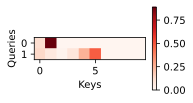

In [ ]:
''' check if attn-weights vanish beyond 2-6 th columns '''
show_heatmaps(attention.attention_weights.reshape(1, 1, 2, 10),
              xlabel='Keys', ylabel='Queries')

#### **Additive Attention**

When queries q and keys k are vectors of different dimensions, we either use
a matrix to address the mismatch or we can use additive attention as the scoring
function. Another benefit to that is that **attention is additive**.
This can lead to some minor computational savings.  



This formula, from the paper by Bahdanau, Cho, and Bengio, is the scoring function for calculating the "energy" or alignment between the decoder's previous hidden state and a specific encoder hidden state.
$$
e_{ij} = v^T_a \tanh(W_a s_{i-1} + U_a h_j)
$$

This term is then fed into a softmax to ensure non-negativity and normalization. An equivalent interpretation is that the query and the key are concatenated and fed into an MLP with a single hidden layer. We implement it using tanh for activation function and removing the bias terms.


In [ ]:
class AdditiveAttention(nn.Module):
  def __init__(self, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.LazyLinear(num_hiddens, bias=False)
    self.W_q = nn.LazyLinear(num_hiddens, bias=False)
    self.w_v = nn.LazyLinear(1, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

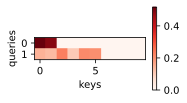

In [ ]:
''' select queries, keys with different dimensions '''
queries = torch.normal(0, 1, (2, 1, 20))
keys = torch.normal(0, 1, (2, 10,2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='keys', ylabel='queries')

#### **Attention Scoring Summary**

We discussed two key attention scoring functions, the dot-product andthe additive attention. They are effective tools for aggregation across sequences of variable length. Dot-product is the mainstay of modern Transformers and Additive attention for queries and keys of diferent lengths. Optimizing these layers is a key area of advance, for instance Nvidia's Transformer Library and Megatron crucially rely on efficient variants of the attention mechanism.

#### **The Bahdanau Attention Mechanism**

We design an encoder-decoder architecture for seq2seq learning based on two RNNs.
The RNN encoder transforms a variable-length sequence into a fixed-shape context
variable. The RNN decoder generates the output target sequence token by token
based on the generated tokens and the context variable.
In an RNN all relevant information about a source sequence is translated into
some internal fixed-dimension state representation by encoder. It is this state
that the decoder uses as the complete and exclusive source of information to
generate the translated sequence. The seq2seq mechanism treats the intermediate
state as a sufficient statistic of the string that has been the input.

There was not enough space in the intermediate representation to store all that
is important in the source sequence. Since the source text had arbitrary length,
they designed a differentiable attention model to align characters, with much
longer trace, where the alignment moves only in one direction.
Inspired by the idea of learning to align, Bahdanau at el (2014) paper proposed
a differentiable attention model without the unidirectional alignment limitation.
When predicting a token, if not all input are relevant, the model aligns only to
the parts of the input that are deemed relevant to the current prediction.
This is used to update the current state before generating the next token.
The Bahdanau attention mechanism has arguably turned into one of the most
influential ideas in deep learning, giving rise to the Transformers.

#### **Model** RNN Encoder-Decoder with Bahdanau attention

In [ ]:
''' The Base Encoder interface for the Enc-Dec architecture '''
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, X, *args):
    raise NotImplementedError

''' The Base Decoder interface for the Enc-Dec architecture '''
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

  # there can be additional arguments (such as length excluding padding)
  def init_state(self, enc_all_outputs, *args):
    raise NotImplementedError

  def forward(self, X, *args):
    raise NotImplementedError

In [ ]:
''' The base class for Encoder-Decoder architecture '''
class EncoderDecoder(Classifier):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
    enc_all_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_all_outputs, *args)
    return self.decoder(dec_X, dec_state)[0]

  def predict_step(self, batch, device, num_steps, save_attention_weights=False):
    batch = [to(a, device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs = [tgt[:, (0)].unsqueeze(1), ]
    attention_weights = [] # Initialize attention_weights here
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

In [ ]:
''' The base class attention based decoder interface '''
class AttentionDecoder(Decoder):
  def __init__(self):
    super().__init__()

  @property
  def attention_weights(self):
    raise NotImplementedError

In [ ]:
''' Initializa weights for Seq2Seq '''
def init_seq2seq(module):
  if type(module) == nn.Linear:
    nn.init.xavier_uniform_(module.weights)
  if type(module) == nn.GRU:
    for param in module._flat_weights_names:
      if 'weight' in param:
        nn.init.xavier_uniform_(module._parameters[param])

In [ ]:
''' RNN implemented with high-level API '''
class RNN(Module):
  def __init__(self,num_inputs, num_hiddens):
      super().__init__()
      self.save_hyperparameters()
      self.rnn = nn.RNN(num_inputs, num_hiddens)

''' The multi-layer GRU model '''
class GRU(RNN):
  def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
    #super().__init__(self)
    Module().__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)

In [ ]:
''' The RNN encoder for sequence to sequence learning '''
class Seq2SeqEncoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
    self.apply(init_seq2seq)

  def forward(self, X, *args):
    embs = self.embedding(astype(transpose(X), int64))
    outputs, state = self.rnn(embs)
    return outputs, state

''' The RNN encoder-decoder for sequence to sequence learning '''
class Seq2Seq(EncoderDecoder):
  def __init__(self, encoder, decoder, tgt_pad, lr):
    super().__init__(encoder, decoder)
    self.save_hyperparameters()

  def validation_step(self, batch):
      Y_hat = self(*batch[:-1])
      self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=self.lr)

**Implementing RNN decoder in Seq2Seq Attention Decoder**

Architecture:
The state of decoder is initialized with hidden states of the encoder, at all
time steps, used as keys and values for attention, and the hidden state of the
encoder at all layers at the final time step. This serves to initalize the hidden state of the encoder.
At each decoding time step, the hidden state of the last layer of the decoder,
obtained at previous step, is used as the query of the attention mechanism.
Both the output and the attention mechanism are concatenated to serve as the
input of the RNN decoder.

In [ ]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
      super().__init__()
      self.attention = AdditiveAttention(num_hiddens, dropout)
      self.embedding = nn.Embedding(vocab_size, embed_size)
      self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
      self.dense = nn.LazyLinear(vocab_size)
      self.apply(init_seq2seq)

  def init_state(self, enc_outputs, enc_valid_lens):
      outputs, hidden_state = enc_outputs
      return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

  def forward(self, X, state):
      enc_outputs, hidden_state, enc_valid_lens = state
      X = self.embedding(X).permute(1, 0, 2)
      outputs, self._attention_weights = [], []
      for x in X:
          query = torch.unsqueeze(hidden_state[-1], dim=1)
          context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
          x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
          out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
          outputs.append(out)
          self._attention_weights.append(self.attention.attention_weights)
      outputs = self.dense(torch.cat(outputs, dim=0))
      return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
      return super()._attention_weights

In [ ]:
''' Test the decoder with attention with a minibatch of 4 sequences, each 7 time steps long'''
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
encoder, decoder

(Seq2SeqEncoder(
   (embedding): Embedding(10, 8)
   (rnn): GRU(8, 16, num_layers=2)
 ),
 Seq2SeqAttentionDecoder(
   (attention): AdditiveAttention(
     (W_k): LazyLinear(in_features=0, out_features=16, bias=False)
     (W_q): LazyLinear(in_features=0, out_features=16, bias=False)
     (w_v): LazyLinear(in_features=0, out_features=1, bias=False)
     (dropout): Dropout(p=0, inplace=False)
   )
   (embedding): Embedding(10, 8)
   (rnn): GRU(24, 16, num_layers=2)
   (dense): LazyLinear(in_features=0, out_features=10, bias=True)
 ))

In [ ]:
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
check_shape(output, (batch_size, num_steps, vocab_size))
check_shape(state[0], (batch_size, num_steps, num_hiddens))
check_shape(state[1][0], (batch_size, num_hiddens))

**Training RNN Seq2Seq Attention Decoder**

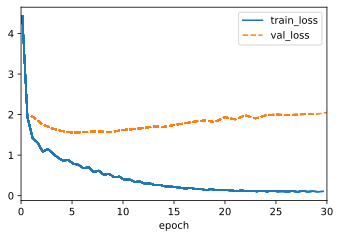

In [ ]:
data = MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

trainer = Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

Translate a few English sentences into French and compute BLEU scores

In [ ]:
english_s = ['go .', 'I lost .', 'He is calm .', 'I\'m home .']
french_s = ['va !', 'j\'ai perdu .','il est calme .', 'je suis chez moi .' ]
preds, _ = model.predict_step(
    data.build(english_s, french_s), gpus[0], data.num_steps)

for en, fr, p in zip(english_s, french_s, preds):
  translation = []
  for token in data.tgt_vocab.to_tokens(p):
    if token == '<eos>':
      break
    translation.append(token)
  print(f'{en} => {translation}, bleu,'
        f'{bleu(' '.join(translation), fr, k=2):.3f}')


go . => ['va', '!'], bleu,1.000
I lost . => ["j'ai", 'perdu', '.'], bleu,1.000
He is calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
I'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Visualize the attention weights

In [ ]:
english_s = ['go .', 'I lost .', 'He is calm .', 'I\'m home .']
french_s = ['va !', 'j\'ai perdu .','il est calme .', 'je suis chez moi .' ]
preds, decoder_attention_weights = model.predict_step(
    data.build([english_s[-1]], [french_s[-1]]), gpus[0], data.num_steps, True)

attention_weights = torch.cat([step[0][0][0] for step in decoder_attention_weights], 0)
attention_weights = attention_weights.reshape(1, 1, -1, data.num_steps)

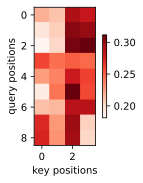

In [ ]:
show_heatmaps(attention_weights[:,:, :, :len(english_s[-1].split()) +1].cpu(), xlabel='key positions', ylabel='query positions')